In [127]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')

In [128]:
# My mac
#data = pd.read_csv("/RawDataCSV/plotsClimateData_11092017.csv")
# My Linux desktop
data = pd.read_csv("/RawDataCSV/idiv_share/plotsClimateData_11092017.csv")


In [129]:
import geopandas as gpd

In [108]:
from django.contrib.gis import geos
from shapely.geometry import Point

In [109]:
data['geometry'] = data.apply(lambda z: Point(z.LON, z.LAT), axis=1)
new_data = gpd.GeoDataFrame(data)

## Let´s reproject to Alberts or something with distance

In [110]:
new_data.crs = {'init':'epsg:4326'}

### Uncomment to reproject
proj string taken from: http://spatialreference.org/

In [111]:
#new_data =  new_data.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")

# Model Fitting Using a GLM 

The general model will have the form:
$$ Biomass(x,y) = \beta_1 AET + \beta_2 Age + Z(x,y) + \epsilon $$
Where:
$\beta_1$ and $\beta_2$ are model parameters, $Z(x,y)$ is the *Spatial Autocorrelation* process and $\epsilon \sim N(0,\sigma^2)$

In [112]:
##### OLD #######
len(data.lon)
#X = data[['AET','StandAge','lon','lat']]
#X = data[['SppN','lon','lat']]
X = data[['lon','lat']]
#Y = data['plotBiomass']
Y = data[['SppN']]
## First step in spatial autocorrelation
#Y = pd.DataFrame(np.zeros(len(Y)))
## Let´s take a small sample only for the spatial autocorrelation
import numpy as np
sample_size = 1000
randindx = np.random.randint(0,X.shape[0],sample_size)
nX = X.loc[randindx]
nY = Y.loc[randindx]


In [113]:
# Import GPFlow
import GPflow as gf
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [0,1] )
k = gf.kernels.Matern32(2,active_dims=[0,1],ARD=False)


In [114]:
#### Let's do the non Gaussian Regression
l = gf.likelihoods.Poisson()
m2 = gf.gpmc.GPMC(nX.as_matrix(),nY.as_matrix().reshape(sample_size,1).astype(float),k,l)

In [115]:
m2.optimize(maxiter=1000) 

      fun: array([ 2598.90097434])
 hess_inv: <1002x1002 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00037865,  0.02959018,  0.01772203, ...,  0.09985113,
        0.05296217, -0.00797089])
  message: 'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 1044
      nit: 1001
   status: 1
  success: False
        x: array([  3.99942233e-02,   3.97994934e-02,   7.95039835e-02, ...,
         4.79597437e-02,  -9.34107549e-01,   3.04283156e+02])

In [16]:
samples = m2.sample(500, verbose=True)

Iteration:  100 	 Acc Rate:  0.0 %
Iteration:  200 	 Acc Rate:  0.0 %
Iteration:  300 	 Acc Rate:  0.0 %
Iteration:  400 	 Acc Rate:  0.0 %
Iteration:  500 	 Acc Rate:  0.0 %


NameError: name 'm' is not defined

In [92]:
import numpy as np
Nn = 300
#dsc = section
#dsc = new_data
dsc = pd.concat([nX,nY],axis=1)

predicted_x = np.linspace(min(dsc.lon),max(dsc.lon),Nn)
predicted_y = np.linspace(min(dsc.lat),max(dsc.lat),Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_y)
## Fake richness
fake_sp_rich = np.ones(len(Xx.ravel()))
predicted_coordinates = np.vstack([ Xx.ravel(), Yy.ravel()]).transpose()
#predicted_coordinates = np.vstack([section.SppN, section.newLon,section.newLat]).transpose()

In [93]:
predicted_coordinates.shape

(90000, 2)

In [94]:
means,variances = m2.predict_y(predicted_coordinates)

In [95]:
means.shape

(90000, 1)

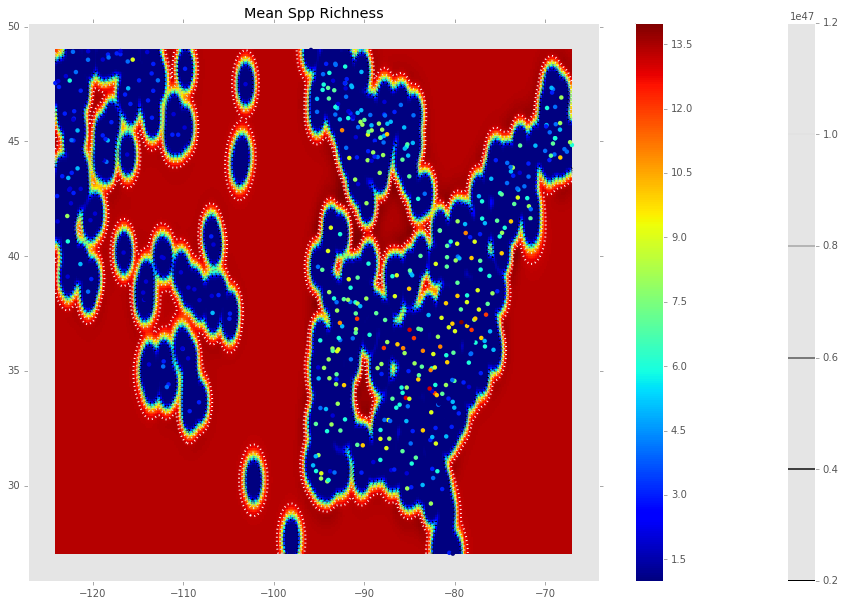

In [96]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
plt.pcolormesh(Xx,Yy,means.reshape(Nn,Nn)) #,cmap=plt.cm.Greens)
cs = plt.contour(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),linewidths=2,cmap=plt.cm.Greys_r,linestyles='dotted')
plt.clabel(cs, fontsize=16,inline=True,fmt='%1.1f')
plt.colorbar()
plt.scatter(dsc.lon,dsc.lat,c=dsc.SppN,edgecolors='')
plt.title("Mean Spp Richness")
plt.colorbar()



In [97]:
model = gf.gpr.GPR(nX.as_matrix(),nY.as_matrix().reshape(sample_size,1).astype(float),k)

In [98]:
model.likelihood.variance = 10
%time model.optimize()

CPU times: user 8.09 s, sys: 964 ms, total: 9.05 s
Wall time: 3.84 s


      fun: 1139.8756151073517
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.82196428e-06,   8.95569900e-06,   6.51240516e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 36
   status: 0
  success: True
        x: array([ 17.66669281,  11.76805979,   5.01538148])

In [99]:
means,variances = model.predict_y(predicted_coordinates)

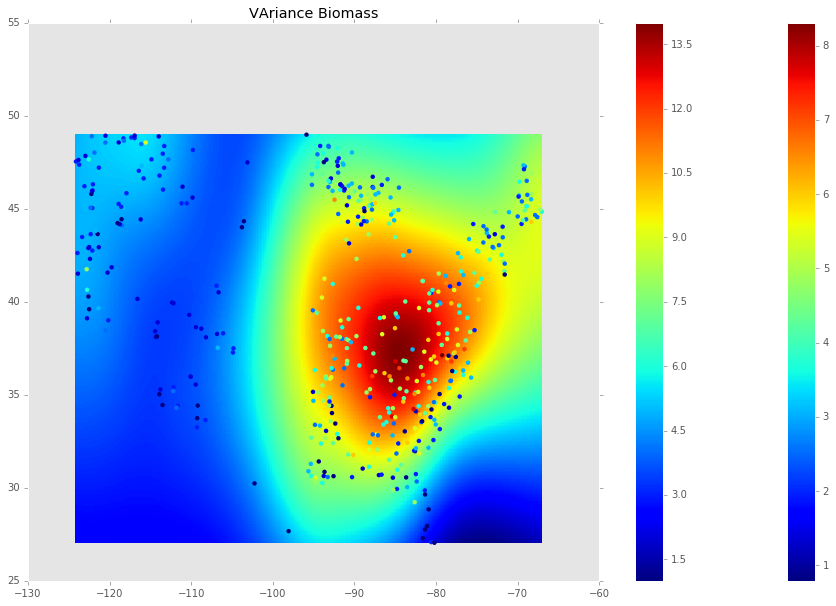

In [100]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
#plt.pcolor(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn))) #,cmap=plt.cm.Greens)
#plt.pcolormesh(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn)))
plt.pcolormesh(Xx,Yy,means.reshape(Nn,Nn))
plt.colorbar()
plt.scatter(dsc.lon,dsc.lat,c=dsc.SppN,edgecolors='')
plt.title("VAriance Biomass")
plt.colorbar()

In [24]:
78000/12*20

130000

In [25]:
plt.pcolormesh?

# Let's bring some spatial data

In [26]:
from sketches.models import Country
Us = Country.objects.filter(name__contains='United States')[1]

In [27]:
from shapely.geometry import MultiPolygon
from shapely.wkt import loads

In [28]:
ppp = loads(Us.geom.wkt)

In [29]:
import cartopy.crs as ccrs

ImportError: No module named cartopy.crs

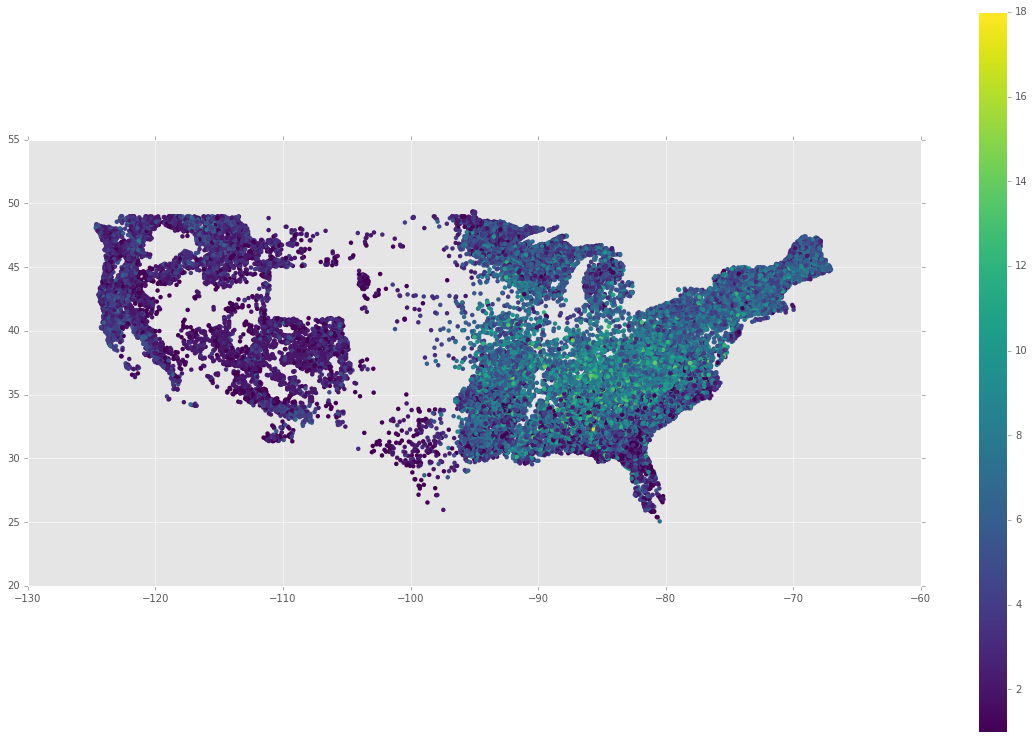

In [30]:
ax= new_data.plot(column='SppN',figsize=(16,10),cmap=colormap,edgecolors='') 
## To add colorbar from stack exchange use:
# add colorbar
fig = ax.get_figure()
# Left
l = 0.95
# Bottom
b = 0
# Width
w = 0.025
# Height
h = 1.0

miny = min(new_data.SppN)
maxy = max(new_data.SppN)
cax = fig.add_axes([l, b, w, h])
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=miny, vmax=maxy))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)






In [92]:
import cartopy

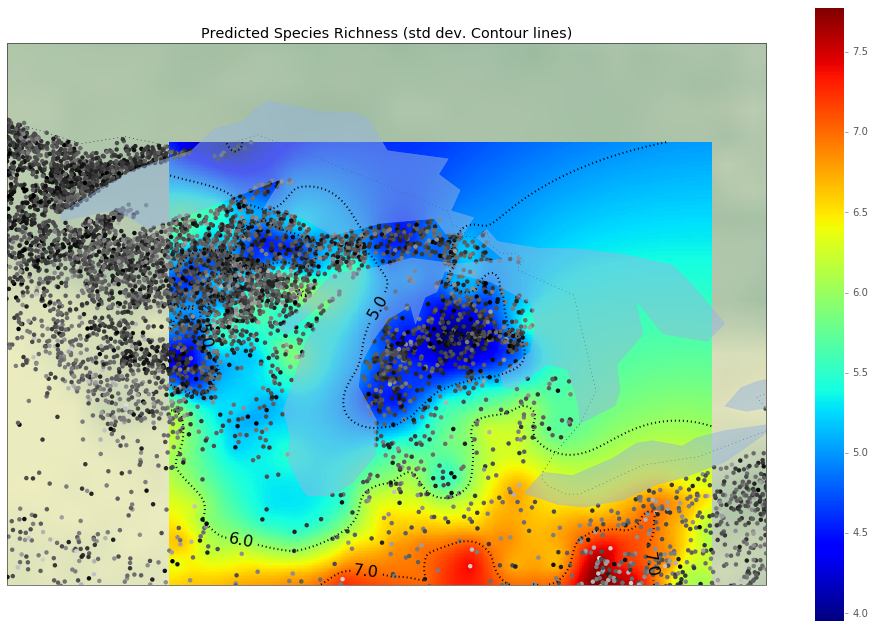

In [103]:
plt.figure(figsize=(17,11))

proj = cartopy.crs.PlateCarree()
ax = plt.subplot(111, projection=proj)


ax = plt.axes(projection=proj)
#algo = new_data.plot(column='SppN',ax=ax,cmap=colormap,edgecolors='')


#ax.set_extent([-93, -70, 30, 50])
ax.set_extent([-93, -79, 40, 50])

#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.stock_img()
#ax.add_geometries(new_data.geometry,crs=cartopy.crs.PlateCarree())
#ax.add_feature(cartopy.feature.RIVERS)
mm = ax.pcolormesh(Xx,Yy,means.reshape(Nn,Nn),transform=proj )
#cs = plt.contour(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),linewidths=2,cmap=plt.cm.Greys_r,linestyles='dotted')
cs = plt.contour(Xx,Yy,means.reshape(Nn,Nn),linewidths=2,colors='k',linestyles='dotted',levels=[4.0,5.0,6.0,7.0,8.0])
plt.clabel(cs, fontsize=16,inline=True,fmt='%1.1f')
ax.scatter(new_data.lon,new_data.lat,c=new_data.SppN,edgecolors='',transform=proj,cmap=plt.cm.Greys_r)
plt.colorbar(mm)
plt.title("Predicted Species Richness (std dev. Contour lines)")


#(x.LON > -90) & (x.LON < -80) & (x.LAT > 40) & (x.LAT < 50)

# Now for all the data

In [ ]:
new_data['newLon'] = section.apply(lambda c : c.geometry.x, axis=1)
new_data['newLat'] = section.apply(lambda c : c.geometry.y, axis=1)


X = new_data[['newLon','newLat']]
#X = data[['lon','lat']]
Y = new_data['SppN']
sample_size = Y.shape[0]
# Import GPFlow
import GPflow as gf
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [0,1] )
model = gf.gpr.GPR(X.as_matrix(),Y.as_matrix().reshape(sample_size,1).astype(float),k)
model.likelihood.variance = 10
%time model.optimize()
import numpy as np
Nn = 1000
dsc = new_data
predicted_x = np.linspace(min(dsc.newLon),max(dsc.newLon),Nn)
predicted_y = np.linspace(min(dsc.newLat),max(dsc.newLat),Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_y)

## Fake richness
fake_sp_rich = np.ones(len(Xx.ravel()))
predicted_coordinates = np.vstack([ Xx.ravel(), Yy.ravel()]).transpose()


#predicted_coordinates = np.vstack([section.SppN, section.newLon,section.newLat]).transpose()
means,variances = model.predict_y(predicted_coordinates)
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
plt.pcolormesh(Xx,Yy,means.reshape(Nn,Nn)) #,cmap=plt.cm.Greens)
plt.colorbar()
plt.scatter(dsc.newLon,dsc.newLat,c=dsc.SppN,edgecolors='')
plt.title("Mean Spp Richness")
plt.colorbar()
